In [1]:
#plots for sample QC stratified by superpopulation
#variants filtered on DP (>20), GQ (>20) and VAF (>0.25) prior to sample QC to remove false positive SNPs
import hail as hl
import pyspark
from hail.plot import show
from bokeh.plotting import output_file, save
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels import robust
import numpy as np

hl.plot.output_notebook()

sc = pyspark.SparkContext()
tmp_dir = "hdfs://spark-master:9820/"
lustre_dir = "file:///lustre/scratch123/qc/"
plot_dir = "/lustre/scratch123/qc/plots/"

hl.init(sc=sc, tmp_dir=tmp_dir, default_reference="GRCh38")

Loading BokehJS ...

2022-04-12 09:54:51 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/backend/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/backend/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 3.1.2
SparkUI available at http://spark-master:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.88-7d39379870da
LOGGING: writing to /home/ubuntu/jupyter/hail-20220412-0954-0.2.88-7d39379870da.log


In [2]:
ht_sample_qc_file = lustre_dir + "matrixtables/mt_pops_sampleqc.ht"
ht = hl.read_table(ht_sample_qc_file)
ht.show()

+-------------------+---------+---------------------+--------------+
| s                 | batch   | sequencing_location | assigned_pop |
+-------------------+---------+---------------------+--------------+
| str               | str     | str                 | str          |
+-------------------+---------+---------------------+--------------+
| "EGAN00003143328" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143329" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143330" | "38268" | "Sanger"            | "AFR"        |
| "EGAN00003143331" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143334" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143336" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143337" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143338" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143339" | "38268" | "Sanger"            | "EUR"        |
| "EGAN00003143340" | "38268" | "Sanger"            | "EUR"        |
+-------------------+---------+---------------------+--------------+

+-------------------------+--------------------------+------------------------+
| sample_qc.dp_stats.mean | sample_qc.dp_stats.stdev | sample_qc.dp_stats.min |
+-------------------------+--------------------------+------------------------+
|                 float64 |                  float64 |                float64 |
+-------------------------+--------------------------+------------------------+
|                3.59e+01 |                 1.38e+01 |               2.10e+01 |
|                3.50e+01 |                 1.12e+01 |               2.10e+01 |
|                3.54e+01 |                 1.16e+01 |               2.10e+01 |
|                3.56e+01 |                 1.27e+01 |               2.10e+01 |
|                3.51e+01 |                 1.08e+01 |               2.10e+01 |
|                3.55e+01 |                 1.24e+01 |               2.10e+01 |
|                3.62e+01 |                 1.49e+01 |               2.10e+01 |
|                3.51e+01 |                 1.19e+01 |               2.10e+01 |
|                3.56e+01 |                 1.23e+01 |               2.10e+01 |
|                3.54e+01 |                 1.20e+01 |               2.10e+01 |
+-------------------------+--------------------------+------------------------+

+------------------------+-------------------------+--------------------------+
| sample_qc.dp_stats.max | sample_qc.gq_stats.mean | sample_qc.gq_stats.stdev |
+------------------------+-------------------------+--------------------------+
|                float64 |                 float64 |                  float64 |
+------------------------+-------------------------+--------------------------+
|               1.32e+03 |                8.52e+01 |                 1.56e+01 |
|               1.04e+03 |                8.40e+01 |                 1.62e+01 |
|               1.30e+03 |                8.44e+01 |                 1.61e+01 |
|               1.01e+03 |                8.48e+01 |                 1.59e+01 |
|               1.01e+03 |                8.41e+01 |                 1.62e+01 |
|               1.00e+03 |                8.45e+01 |                 1.60e+01 |
|               1.53e+03 |                8.54e+01 |                 1.55e+01 |
|               1.10e+03 |                8.41e+01 |                 1.61e+01 |
|               1.17e+03 |                8.47e+01 |                 1.58e+01 |
|               1.16e+03 |                8.46e+01 |                 1.59e+01 |
+------------------------+-------------------------+--------------------------+

+------------------------+------------------------+---------------------+
| sample_qc.gq_stats.min | sample_qc.gq_stats.max | sample_qc.call_rate |
+------------------------+------------------------+---------------------+
|                float64 |                float64 |             float64 |
+------------------------+-----------

In [3]:
#scatter plot of nSNP vs rTi/Tv to check that adding the high nSNP samples back in wasn't a mistake - seems OK so proceeed
p = hl.plot.scatter(ht.sample_qc.n_snp, ht.sample_qc.r_ti_tv, xlabel='nSNP', ylabel='Ti/Tv ratio', label=ht.batch, collect_all = True)
show(p)

In [5]:
#look at pass/fail per pop for each metric
annot_tsv = lustre_dir + "annotations/sample_qc_by_pop.tsv.bgz"
df = pd.read_csv(annot_tsv, compression="gzip",sep="\t")
df['batch'] = df['batch'].astype(str)
df.head()

,s,batch,sequencing_location,assigned_pop,sample_qc,fail_heterozygosity_rate,fail_n_snp,fail_r_ti_tv,fail_n_transition,fail_n_transversion,fail_r_insertion_deletion,fail_n_insertion,fail_n_deletion,fail_r_het_hom_var,qc_metrics_filters
0,EGAN00003143328,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.88350520641446,""stdev"":...",False,False,False,False,False,False,False,False,False,[]
1,EGAN00003143329,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":34.9981589796809,""stdev"":1...",False,False,False,False,False,False,False,False,False,[]
2,EGAN00003143330,38268.0,Sanger,AFR,"{""dp_stats"":{""mean"":35.399220303844835,""stdev""...",False,False,False,False,False,False,False,False,False,[]
3,EGAN00003143331,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.60963475440693,""stdev"":...",False,False,False,False,False,False,False,False,False,[]
4,EGAN00003143334,38268.0,Sanger,EUR,"{""dp_stats"":{""mean"":35.076327330274616,""stdev""...",False,False,False,False,False,False,False,False,False,[]


In [6]:
df.groupby("assigned_pop")["fail_heterozygosity_rate"].value_counts()

assigned_pop  fail_heterozygosity_rate
AFR           False                         196
              True                            6
AMR           False                           9
              True                            1
EAS           False                          19
EUR           False                       14481
              True                           25
SAS           False                          85
              True                            2
oth           False                         145
              True                            4
Name: fail_heterozygosity_rate, dtype: int64

In [8]:
df.groupby("assigned_pop")["qc_metrics_filters"].value_counts()

assigned_pop  qc_metrics_filters                                                                                                                         
AFR           []                                                                                                                                               195
              ["heterozygosity_rate"]                                                                                                                            6
              ["n_transition","n_transversion","n_deletion","n_snp","n_insertion"]                                                                               1
AMR           []                                                                                                                                                 8
              ["heterozygosity_rate"]                                                                                                                            1
              ["n_snp","n_trans

In [11]:
def plot_fails_by_pop(metric, label):
    #prepare data for seaborn plot
    #unstack fills in missing values, then convert to string for axis labels
    xnames = df.groupby("assigned_pop")[metric].value_counts().unstack(fill_value=0).stack().index.tolist()
    xnames = [str(x).replace("'", "").replace(',', '').replace('(', '').replace(')', '').replace('False', 'Pass').replace('True', 'Fail') for x in xnames]

    #values for Y - normalised counts
    yvals = df.groupby("assigned_pop")[metric].value_counts(normalize=True).unstack(fill_value=0).stack()*100

    a4_dims = (16.69,8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.xticks(rotation=70)

    ping=sns.barplot(x=xnames, y=yvals)
    plottitle = "Percentage of samples passing/failing " + label +  " filter"
    ax.set(xlabel='Population code, pass/fail', ylabel='Percentage of samples', title=plottitle)
    for p in ping.patches:
        ping.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    plotfile = plot_dir + "/sample_qc/" + metric + "_sample_qc_by_pop_filtered.png"
    ping.figure.savefig(plotfile)
    

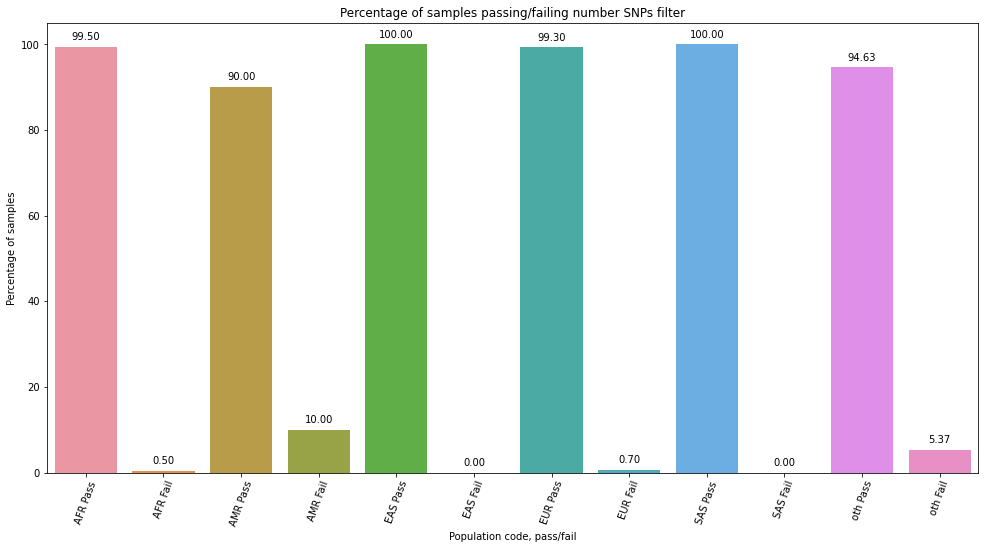

In [13]:
plot_fails_by_pop("fail_n_snp", "number SNPs")

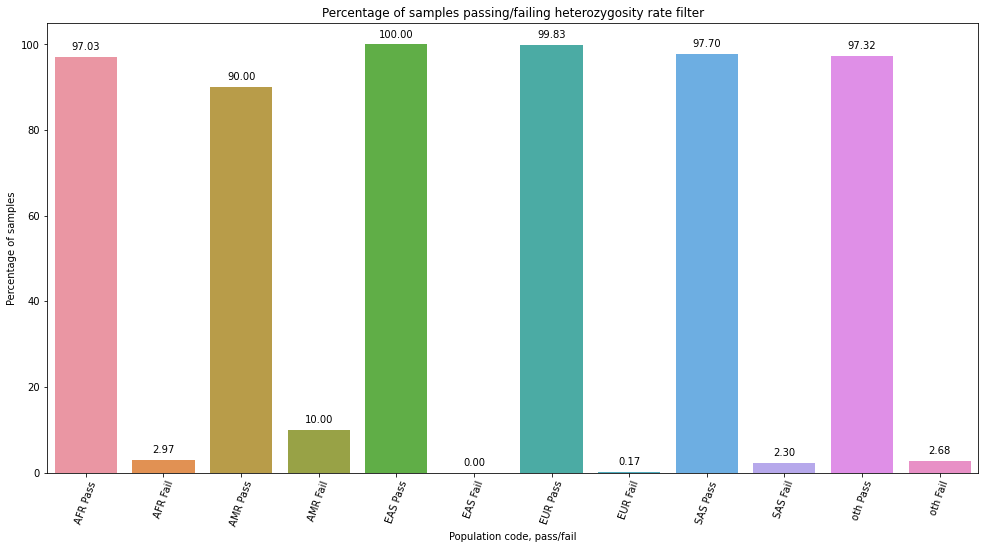

In [14]:
plot_fails_by_pop("fail_heterozygosity_rate", "heterozygosity rate")

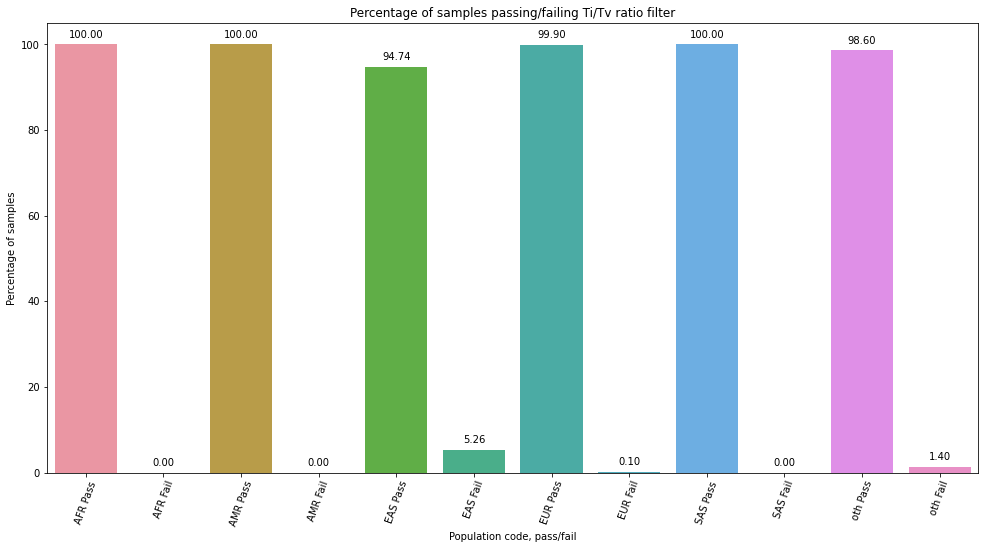

In [15]:
plot_fails_by_pop("fail_r_ti_tv", "Ti/Tv ratio")

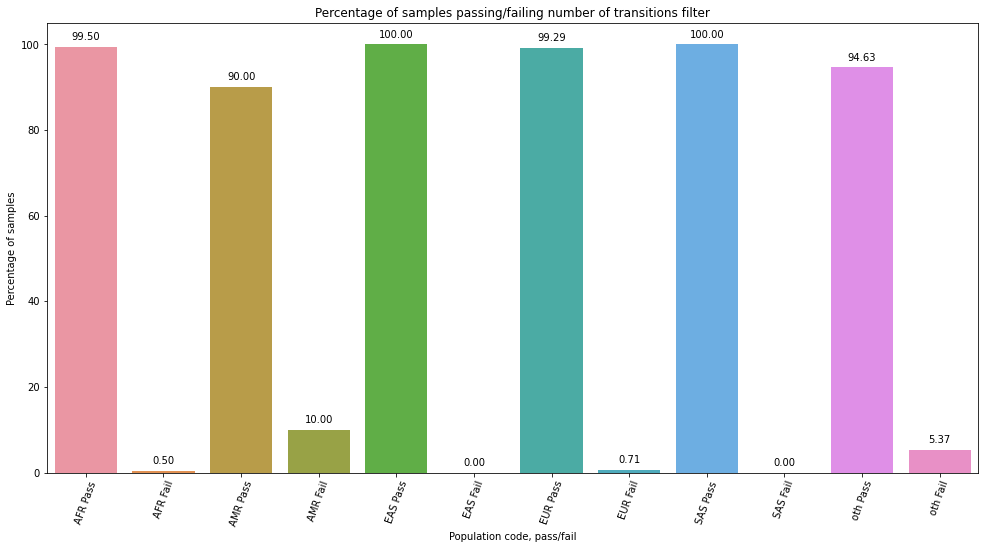

In [16]:
plot_fails_by_pop("fail_n_transition", "number of transitions")

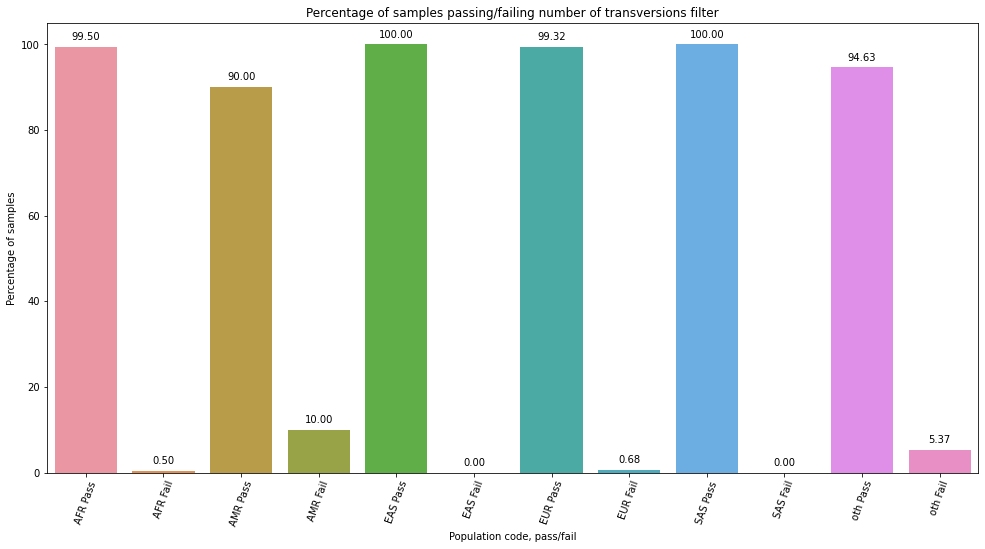

In [17]:
plot_fails_by_pop("fail_n_transversion", "number of transversions")

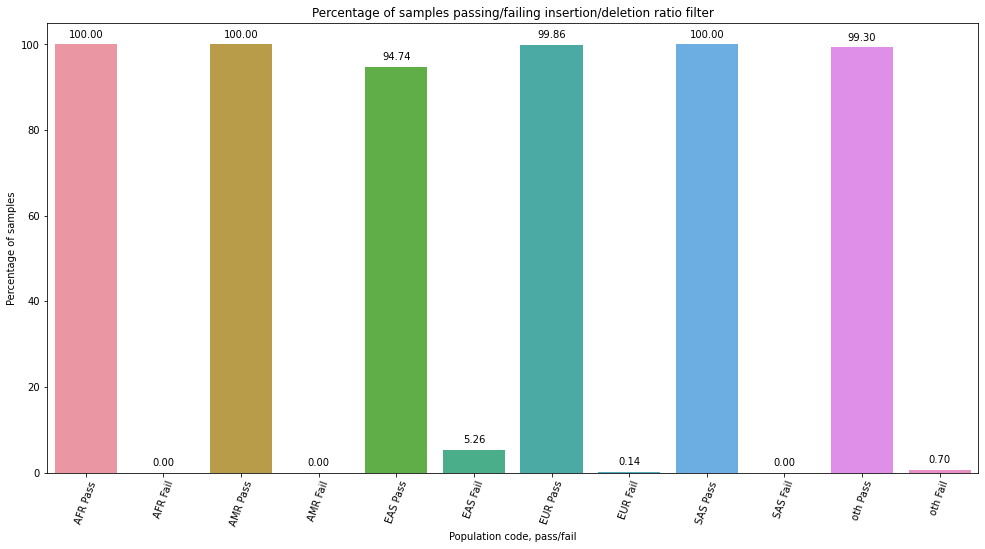

In [18]:
plot_fails_by_pop("fail_r_insertion_deletion", "insertion/deletion ratio")

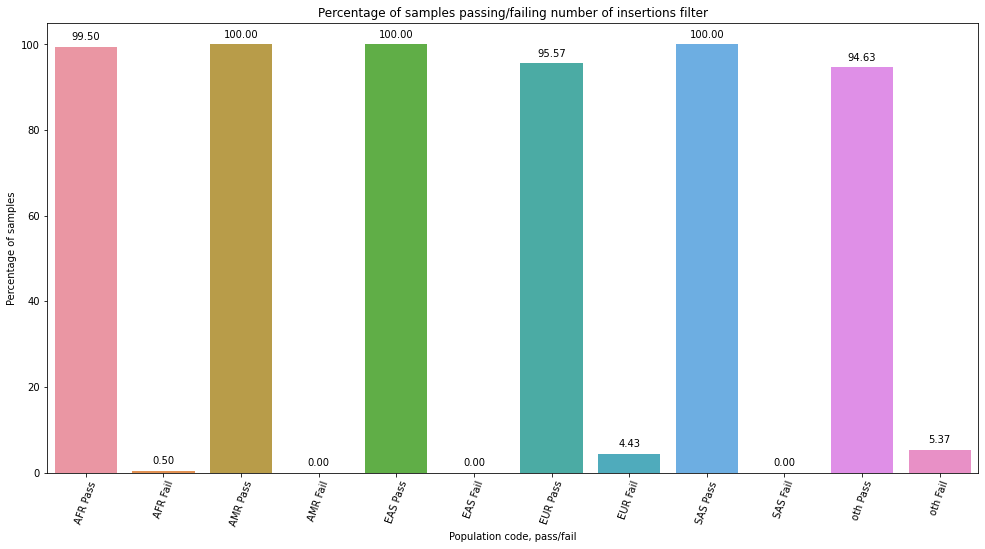

In [19]:
plot_fails_by_pop("fail_n_insertion", "number of insertions")

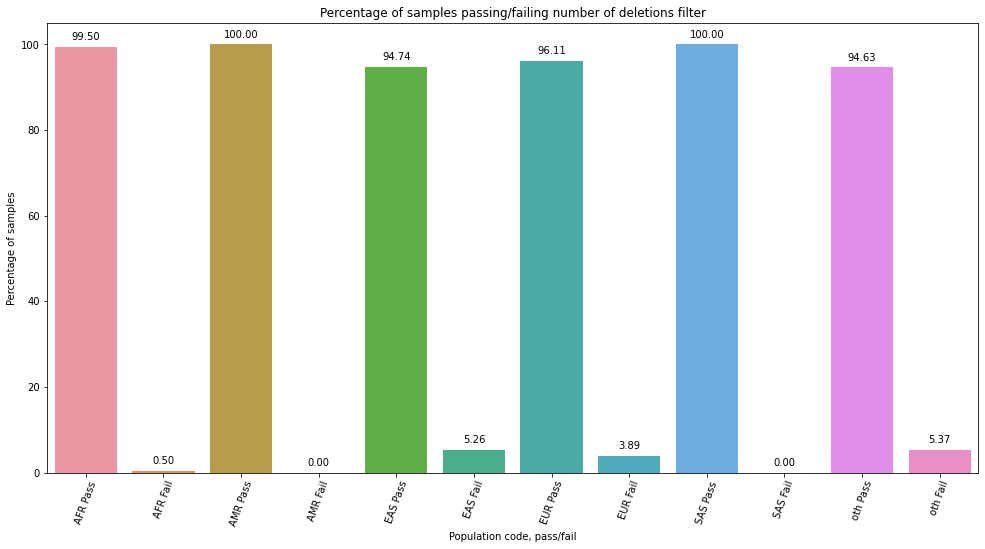

In [20]:
plot_fails_by_pop("fail_n_deletion", "number of deletions")

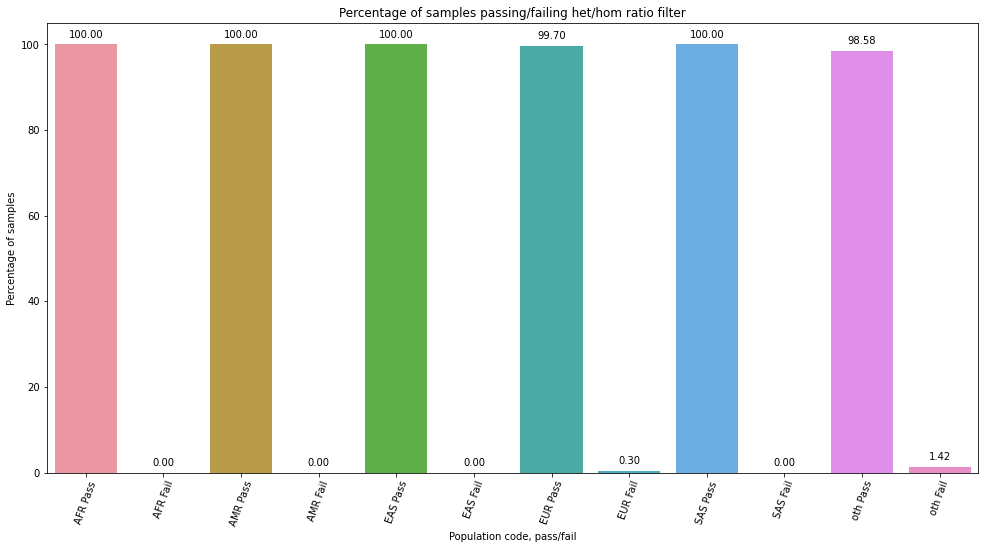

In [21]:
plot_fails_by_pop("fail_r_het_hom_var", "het/hom ratio")

In [22]:
#convert to sample QC hail table pandas df to do violin plots

df_sqc = ht.to_pandas(flatten=True)
df_sqc.head()

,s,batch,sequencing_location,assigned_pop,sample_qc.dp_stats.mean,sample_qc.dp_stats.stdev,sample_qc.dp_stats.min,sample_qc.dp_stats.max,sample_qc.gq_stats.mean,sample_qc.gq_stats.stdev,...,sample_qc.n_snp,sample_qc.n_insertion,sample_qc.n_deletion,sample_qc.n_transition,sample_qc.n_transversion,sample_qc.n_star,sample_qc.r_ti_tv,sample_qc.r_het_hom_var,sample_qc.r_insertion_deletion,sample_qc.heterozygosity_rate
0,EGAN00003143328,38268,Sanger,EUR,35.883505,13.755483,21.0,1319.0,85.206368,15.619718,...,64435,2124,2510,46100,18335,2954,2.514317,1.668674,0.846215,0.006268
1,EGAN00003143329,38268,Sanger,EUR,34.998159,11.194896,21.0,1041.0,83.985908,16.210103,...,58173,1740,2005,41844,16329,2121,2.562557,1.713605,0.867830,0.006376
2,EGAN00003143330,38268,Sanger,AFR,35.399220,11.583817,21.0,1299.0,84.415834,16.068627,...,71306,2243,2632,51417,19889,2617,2.585198,2.133077,0.852204,0.008234
3,EGAN00003143331,38268,Sanger,EUR,35.609635,12.675446,21.0,1011.0,84.764505,15.875173,...,59067,1835,2134,42450,16617,2233,2.554613,1.752174,0.859888,0.006237
4,EGAN00003143334,38268,Sanger,EUR,35.076327,10.834952,21.0,1008.0,84.082909,16.182223,...,60019,1846,2148,43210,16809,2196,2.570647,1.714133,0.859404,0.006305


In [32]:
def make_violin_plot(metric, label):
    plottitle = label
    vio = sns.catplot(x="assigned_pop", y=metric,
            kind="violin",
            data=df_sqc).set(title=plottitle)
    plotfile = plot_dir + "sample_qc/" + metric + "_violin_filtered.png"
    vio.figure.savefig(plotfile)



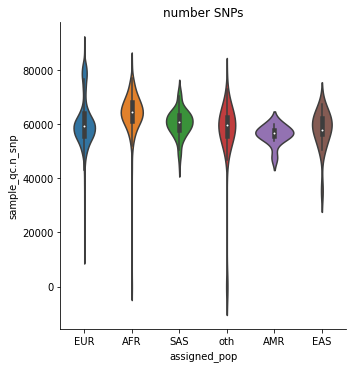

In [33]:
make_violin_plot("sample_qc.n_snp", "number SNPs")

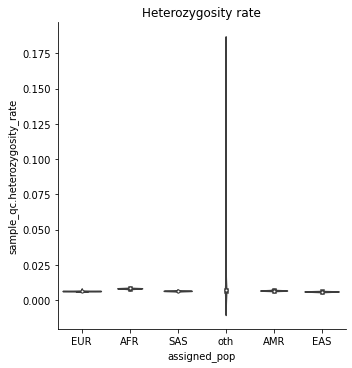

In [34]:
make_violin_plot("sample_qc.heterozygosity_rate", "Heterozygosity rate")

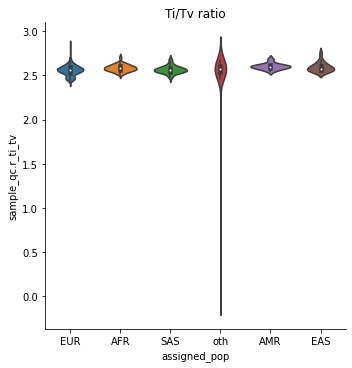

In [35]:
make_violin_plot("sample_qc.r_ti_tv", "Ti/Tv ratio")

In [36]:
def make_violin_plot_batch(metric, label):
    plottitle = label
    vio = sns.catplot(x="batch", y=metric,
            kind="violin",
            data=df_sqc).set(title=plottitle)
    plotfile = plot_dir + "sample_qc/" + metric + "_runid_violin_filtered.png"
    vio.figure.savefig(plotfile)

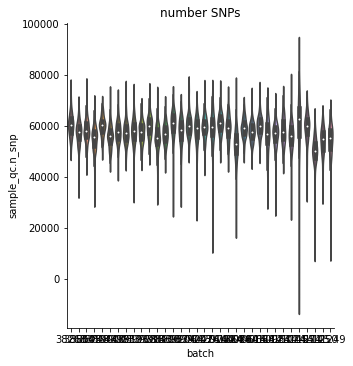

In [37]:
make_violin_plot_batch("sample_qc.n_snp", "number SNPs")

In [62]:
#violin plots with +/-4MAD

#create subset for each assigned pop, and convert each to a pandas dataframe
AFRht = ht.filter(ht.assigned_pop == 'AFR')
AMRht = ht.filter(ht.assigned_pop == 'AMR')
EURht = ht.filter(ht.assigned_pop == 'EUR')
EASht = ht.filter(ht.assigned_pop == 'EAS')
SASht = ht.filter(ht.assigned_pop == 'SAS')
othht = ht.filter(ht.assigned_pop == 'oth')

AFR_df = AFRht.to_pandas(flatten=True).dropna()
AMR_df = AMRht.to_pandas(flatten=True).dropna()
EUR_df = EURht.to_pandas(flatten=True).dropna()
EAS_df = EASht.to_pandas(flatten=True).dropna()
SAS_df = SASht.to_pandas(flatten=True).dropna()
oth_df = othht.to_pandas(flatten=True).dropna()
all_df = ht.to_pandas(flatten=True).dropna()



In [64]:
#violin plots
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Superpopulation')
    
def violin_plot(metric, label):
    
    m1 = AFR_df[metric].median()
    m2 = AMR_df[metric].median()
    m3 = EAS_df[metric].median()
    m4 = EUR_df[metric].median()
    m5 = SAS_df[metric].median()
    m6 = oth_df[metric].median()
    mad1 = robust.mad(AFR_df[metric])
    mad2 = robust.mad(AMR_df[metric])
    mad3 = robust.mad(EAS_df[metric])
    mad4 = robust.mad(EUR_df[metric])
    mad5 = robust.mad(SAS_df[metric])
    mad6 = robust.mad(oth_df[metric])
    meds = np.array([m1, m2, m3, m4, m5, m6])
    q1 = np.array([m1-(4*mad1), m2-(4*mad2), m3-(4*mad3), m4-(4*mad4), m5-(4*mad5), m6-(4*mad6)])
    q2 = np.array([m1+(4*mad1), m2+(4*mad2), m3+(4*mad3), m4+(4*mad4), m5+(4*mad5), m6+(4*mad6)])

    fig, ax = plt.subplots()
    plottitle = label + " per superpopulation: \nMedians and +/-4xMAD per superpopulation shown"
    ax.set_title(plottitle)
    ax.set_ylabel(label)

    violin_parts = ax.violinplot([AFR_df[metric], AMR_df[metric], EAS_df[metric], EUR_df[metric], SAS_df[metric], oth_df[metric]], showmeans=False, showmedians=False, showextrema=False)

    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('black')
    
    inds = np.arange(1, len(meds) + 1)
    ax.scatter(inds, meds, marker='o', color='black', s=30, zorder=3)
    ax.vlines(inds, q1, q2, color='k', linestyle='-', lw=2)
    labels = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS', 'oth']
    set_axis_style(ax, labels)

    #plt.show()
    metric = metric.replace('.', '_')
    plotfile = plot_dir + '/sample_qc/' + metric + '_violin_with_4MAD.png'
    plt.savefig(plotfile, dpi=100)

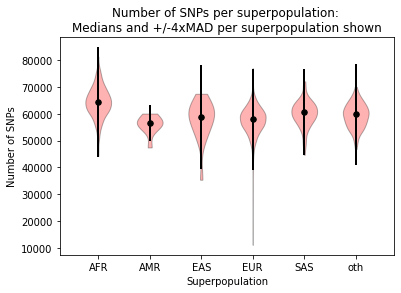

In [75]:
violin_plot('sample_qc.n_snp', 'Number of SNPs')

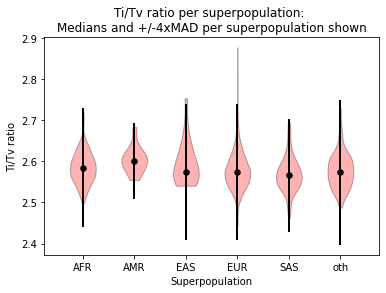

In [66]:
violin_plot('sample_qc.r_ti_tv', 'Ti/Tv ratio')

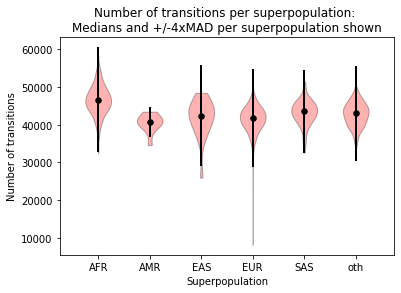

In [74]:
violin_plot('sample_qc.n_transition', 'Number of transitions')

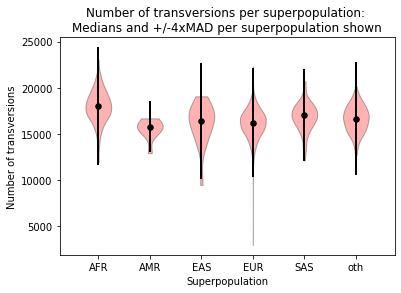

In [73]:
violin_plot('sample_qc.n_transversion', 'Number of transversions')

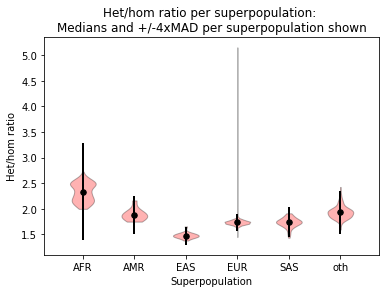

In [69]:
violin_plot('sample_qc.r_het_hom_var', 'Het/hom ratio')

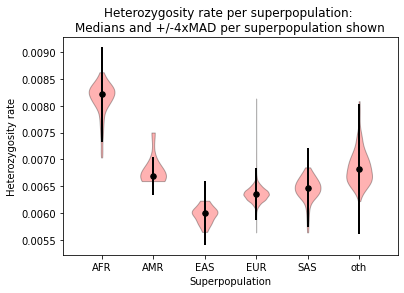

In [70]:
violin_plot('sample_qc.heterozygosity_rate', 'Heterozygosity rate')

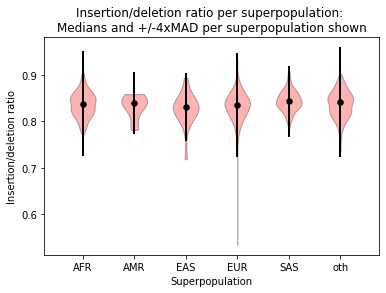

In [71]:
violin_plot('sample_qc.r_insertion_deletion', 'Insertion/deletion ratio')

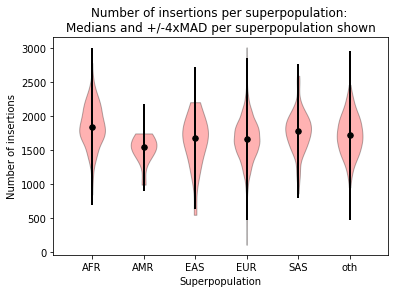

In [72]:
violin_plot('sample_qc.n_insertion', 'Number of insertions')

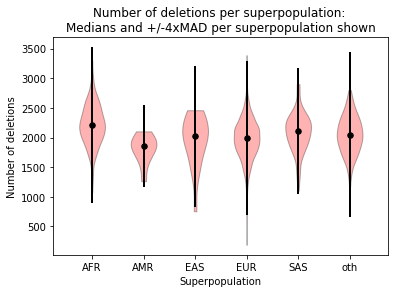

In [76]:
violin_plot('sample_qc.n_deletion', 'Number of deletions')